In [49]:
import pandas as pd
# -*- coding: utf-8 -*-
import click
import logging
from pathlib import Path
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
import itertools
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [50]:
import array
import random
import json

import numpy

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
from scoop import futures


In [51]:
data = pd.read_csv('/Users/b1017579/Documents/Projects/Fish/fish-stock-optimiser/data/raw/fish_3.csv')
data.head()

,spp,k1,k2,safety,kobe,yield,yieldAav
0,brill,1.595569,0.918369,0.903827,0.633333,0.660847,0.880955
1,brill,0.335139,0.567360,0.602453,0.366667,1.046468,0.895385
2,brill,0.791821,1.079009,0.724056,0.366667,1.241589,0.845822
3,brill,0.077107,1.312772,0.604167,0.000000,1.262381,0.836518
4,brill,1.318895,0.581586,0.895197,0.633333,0.859258,0.961509


In [52]:
by_fish = data.copy()
# single_optimiser['reward'] = single_optimiser.safety + single_optimiser['kobe.n'] + single_optimiser.yield
# single_optimiser['reward'] = data[['safety','kobe.n','yield','yieldAav']].sum(axis=1)
by_fish['reward'] = 1*data['safety']+1*data['kobe']+1*data['yield']+1*data['yieldAav']
by_fish = by_fish[['spp', 'k1','k2','kobe','yield','reward']]
by_fish['reward'] = by_fish['reward'].apply(lambda x: x*-1)
by_fish.head()

,spp,k1,k2,kobe,yield,reward
0,brill,1.595569,0.918369,0.633333,0.660847,-3.078963
1,brill,0.335139,0.567360,0.366667,1.046468,-2.910972
2,brill,0.791821,1.079009,0.366667,1.241589,-3.178134
3,brill,0.077107,1.312772,0.000000,1.262381,-2.703066
4,brill,1.318895,0.581586,0.633333,0.859258,-3.349297


In [53]:
def fit_model(m, reward):
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    max_bound = 1 * np.ones(2)
    min_bound = - max_bound
    bounds = (min_bound, max_bound)

    X = np.array(m[['k1','k2']])
    y = np.array(m[reward])
#     clf = MLPRegressor(hidden_layer_sizes=(50, 30, 50), activation='relu', solver='adam', alpha=1,
#                                         batch_size='auto', learning_rate='constant', learning_rate_init=0.05, power_t=0.5,
#                                         max_iter=10000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False,
#                                         momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    svr_model = SVR(gamma='scale', C=1.0, epsilon=0.1)
    param_grid={
    'kernel': ['rbf'],
        
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'epsilon': [0.01, 0.1, 0.2, 0.5, 0.7, 1.0, 10],
#     'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 100]
    }
        
    clf = GridSearchCV(estimator=svr_model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=True, scoring='neg_median_absolute_error', return_train_score=True)
    clf.fit(X, y)
    
    return clf


In [54]:
def predictor_rewards(data):
    clf_safety = fit_model(data, 'safety')
    clf_kobe = fit_model(data, 'kobe')
    clf_yield = fit_model(data, 'yield')
    clf_yieldAav = fit_model(data, 'yieldAav')
    return (clf_safety, clf_kobe, clf_yield, clf_yieldAav)

In [55]:
def maximise_function(individual, clf_safety, clf_kobe, clf_yield, clf_yieldAav):
    individual = np.array(individual).reshape(1, -1)
    safety = float(clf_safety.predict(individual))
    kobe = float(clf_kobe.predict(individual))
    yield_val = float(clf_yield.predict(individual))
    yieldAav = float(clf_yieldAav.predict(individual))
    
    return (safety, kobe, yield_val, yieldAav)

In [56]:
creator.create("FitnessMin", base.Fitness, weights=(1.0, 1.0, 1.0, 1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = 0.0, 1.0

# Functions zdt4 has bounds x1 = [0, 1], xn = [-5, 5], with n = 2, ..., 10
# BOUND_LOW, BOUND_UP = [0.0] + [-5.0]*9, [1.0] + [5.0]*9

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10
NDIM = 2

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox.register("map_distributed", futures.map)

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", maximise_function)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)


def main(clf_safety, clf_kobe, clf_yield, clf_yieldAav, seed=None, initial_guess = None):
    # random.seed(seed)

    toolbox.register("evaluate", maximise_function, clf_safety = clf_safety, clf_kobe = clf_kobe, clf_yield = clf_yield, clf_yieldAav = clf_yieldAav)
    
    NGEN = 100
    MU = 400
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    pop = toolbox.population(n=MU)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map_distributed(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        print("-- Generation %i --" % gen)

        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)

            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map_distributed(toolbox.evaluate, invalid_ind)

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        print("  Evaluated %i individuals" % len(invalid_ind))


        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

        best_ind = tools.selBest(pop, 1)[0]

        print("Best individual is %s, %s" %
          (np.rint(best_ind), best_ind.fitness.values))

        front = numpy.array(
            [ind.fitness.values + tuple(ind) for ind in pop])

        # np.savetxt('{}/src/models/optimisation_algorithms/genetic_algorithms/pareto_front/k_meansdata/pareto_front_{}.csv'.format(project_dir, gen), front, delimiter=",")
        np.savetxt('/Users/b1017579/Documents/Projects/Fish/fish-stock-optimiser/models/results/nsga_ii/first_run.csv'.format(), front, delimiter=",")


#         Plotting pareto front
        
        fig = plt.figure(1)

        columns = 2
        rows = 1

        fig.add_subplot(rows, columns, 1)
        plt.scatter(front[:, 0], front[:, 1], c="b")

        fig.add_subplot(rows, columns, 2)
        plt.scatter(front[:, 1], front[:, 2], c="b")

        # # plt.savefig('{}/src/models/optimisation_algorithms/genetic_algorithms/pareto_front/k_means/images/pareto_front_{}.png'.format(project_dir, gen))
        # plt.savefig('{}/optimisation/algorithms/pareto_front/nsga_ii/images/pareto_front_{}.png'.format(project_dir, gen))
        
        plt.close()

        fig = plt.figure(1)
        ax = Axes3D(fig)
        ax.scatter(front[:, 0], front[:, 1], front[:, 2], c='red')

        ax.axis("tight")
#         fig.savefig('{}/optimisation/algorithms/pareto_front/nsga_ii/images/pareto_front_3D_{}.png'.format(project_dir, gen))
        # fig.savefig('{}/src/models/optimisation_algorithms/genetic_algorithms/pareto_front/k_means/images/pareto_front_3D_{}.png'.format(project_dir, gen))
        plt.close()

    # print("Final population hypervolume is %f" %
    #   hypervolume(pop, [11.0, 11.0]))

#     return pop, logbook
    return front

/Users/b1017579/.pyenv/versions/3.6.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/b1017579/.pyenv/versions/3.6.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
pop, stats = main()
pop.sort(key=lambda x: x.fitness.values)


In [15]:
pareto = pd.read_csv('/Users/b1017579/Documents/Projects/Fish/fish-stock-optimiser/models/results/nsga_ii/first_run.csv', names=['safety', 'kobe', 'yield_val', 'yieldAav', 'k1', 'k2'])
pareto.head()

,safety,kobe,yield_val,yieldAav,k1,k2
0,0.892742,0.668711,0.657212,0.912858,1.000000,5.884182e-15
1,0.875139,0.642220,0.753899,0.916218,0.630250,8.049117e-16
2,0.688031,0.127238,1.097968,0.886728,0.485366,8.234363e-01
3,0.688031,0.127238,1.097968,0.886728,0.485366,8.234363e-01
4,0.886109,0.670980,0.795623,0.910726,0.897487,1.635228e-01


In [62]:
def threeD_plotter(dat):
    for i in range(4):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        print(pareto.columns[i])
        ax.plot_trisurf(dat['k1'], dat['k2'], dat.iloc[:,i], cmap=plt.cm.viridis, linewidth=0.2)
        plt.xlabel("k1")
        plt.ylabel("k2")

        plt.show()

Yield and Kobe


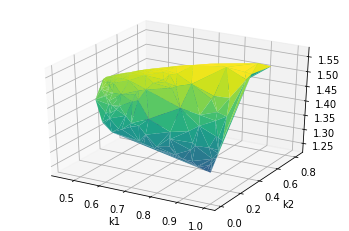

Text(0, 0.5, 'k2')

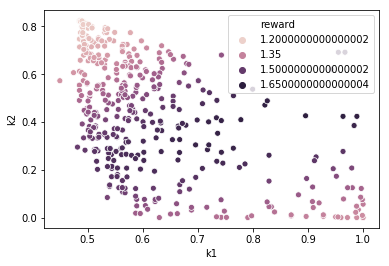

In [26]:
yield_kobe = pareto.copy()
yield_kobe['reward'] = pareto['kobe']+pareto['yield_val']

fig = plt.figure()
ax = fig.gca(projection='3d')
print("Yield and Kobe")
ax.plot_trisurf(yield_kobe['k1'], yield_kobe['k2'], yield_kobe.reward, cmap=plt.cm.viridis, linewidth=0.2)
plt.xlabel("k1")
plt.ylabel("k2")

plt.show()

sns.scatterplot(yield_kobe['k1'], yield_kobe['k2'], hue = yield_kobe.reward)
plt.xlabel("k1")
plt.ylabel("k2")

safety


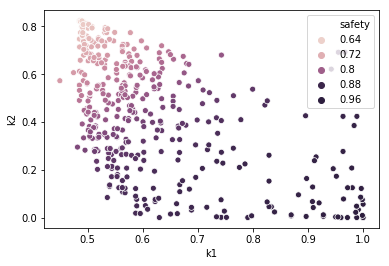

kobe


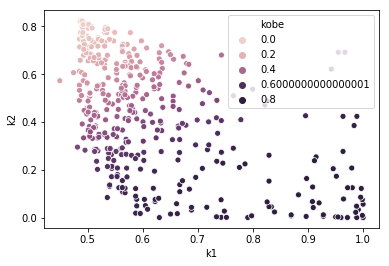

yield_val


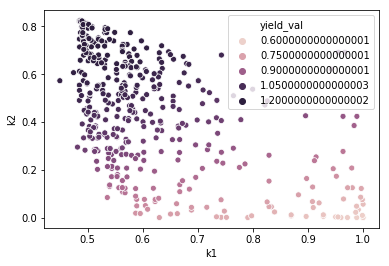

yieldAav


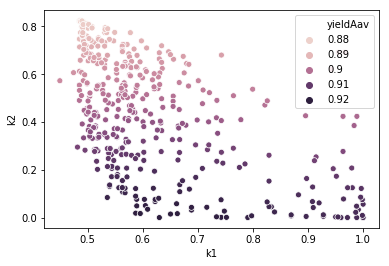

In [27]:
def twoD_plotter(dat):
    for i in range(4):
        fig = plt.figure()
        print(pareto.columns[i])
        sns.scatterplot(dat['k1'], dat['k2'], hue = dat.iloc[:,i])
        plt.xlabel("k1")
        plt.ylabel("k2")

        plt.show()
        plt.close()

## Each Fish

In [57]:
def optimise_each_stock(dat):
    safety, kobe, yield_val, yieldAav = predictor_rewards(dat)
    front = main(safety, kobe, yield_val, yieldAav)
    return front

In [59]:
each_stock_results = data.groupby('spp').apply(optimise_each_stock)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


gen	evals	std                                          	min                                          	avg                                          	max                                          
0  	400  	[0.11628504 0.19931974 0.09493976 0.01462936]	[0.55825128 0.05708639 0.72877067 0.83713288]	[0.72919277 0.354822   1.102725   0.88946921]	[0.93601269 0.71771383 1.19915244 0.90209758]
-- Generation 1 --
  Evaluated 400 individuals
1  	400  	[0.08606019 0.15836095 0.10372071 0.00346244]	[0.62720251 0.14821013 0.7639888  0.88281044]	[0.79637007 0.45844779 1.09208954 0.89846403]	[0.94837391 0.72098764 1.19917856 0.90209758]
Best individual is [1. 0.], (0.9483739094327945, 0.7124183665394814, 0.8553316615584419, 0.900516664216932)
-- Generation 2 --
  Evaluated 400 individuals
2  	400  	[0.0834803  0.1557002  0.09531859 0.00194253]	[0.62306209 0.14169492 0.82355653 0.89182496]	[0.80699679 0.47633288 1.09825104 0.89967338]	[0.94837391 0.72098764 1.19939797 0.90210596]
Best individual is [1.

  Evaluated 400 individuals
24 	400  	[0.08974816 0.16944734 0.10008358 0.00167061]	[0.64229717 0.1764321  0.85895791 0.89594211]	[0.80715971 0.47435862 1.10029575 0.8995877 ]	[0.9544572  0.73909922 1.20127204 0.90210608]
Best individual is [1. 0.], (0.9544572049612414, 0.7336561842772513, 0.8777397424467238, 0.9002996532250522)
-- Generation 25 --
  Evaluated 400 individuals
25 	400  	[0.08968841 0.16883667 0.10190048 0.00162678]	[0.64229717 0.1764321  0.85765084 0.89594211]	[0.81752171 0.49426762 1.08890675 0.89976036]	[0.9544572  0.73910459 1.20127204 0.90210608]
Best individual is [1. 0.], (0.9544572049612414, 0.7336561842772513, 0.8777397424467238, 0.9002996532250522)
-- Generation 26 --
  Evaluated 400 individuals
26 	400  	[0.08897289 0.16789063 0.10027317 0.00161365]	[0.64229717 0.1764321  0.85765084 0.89594211]	[0.81000664 0.48077957 1.09752478 0.89962664]	[0.9544572  0.73910459 1.20127204 0.90210608]
Best individual is [1. 0.], (0.9544572049612414, 0.7336561842772513, 0.87773

  Evaluated 400 individuals
48 	400  	[0.09025833 0.16919406 0.10241672 0.00162256]	[0.64314333 0.17802806 0.85901755 0.89598056]	[0.80837192 0.47685382 1.09800388 0.89961974]	[0.95447529 0.73913393 1.20127634 0.90210633]
Best individual is [1. 0.], (0.9544752914442339, 0.7323217476892769, 0.8741520225440553, 0.900309669712064)
-- Generation 49 --
  Evaluated 400 individuals
49 	400  	[0.09158067 0.17152009 0.10304838 0.00164048]	[0.64314333 0.17802806 0.85226556 0.89598056]	[0.81389579 0.48750808 1.09135512 0.89971381]	[0.95447529 0.73913393 1.20127634 0.90210633]
Best individual is [1. 0.], (0.9544752914442339, 0.7323217476892769, 0.8741520225440553, 0.900309669712064)
-- Generation 50 --
  Evaluated 400 individuals
50 	400  	[0.0907998  0.17045348 0.10130798 0.00163758]	[0.64314333 0.17802806 0.85226556 0.89608812]	[0.80677681 0.47450963 1.09976249 0.89956635]	[0.95447529 0.73913393 1.20127634 0.90210633]
Best individual is [1. 0.], (0.9544752914442339, 0.7323217476892769, 0.8741520

  Evaluated 400 individuals
72 	400  	[0.09238876 0.17348558 0.10463091 0.00163873]	[0.64314283 0.17802705 0.85506844 0.89597036]	[0.8143403  0.48964545 1.08909874 0.89964509]	[0.9544805  0.73913735 1.20127645 0.90210633]
Best individual is [1. 0.], (0.9544804955866146, 0.733004911649622, 0.8759142539130232, 0.9003046225076081)
-- Generation 73 --
  Evaluated 400 individuals
73 	400  	[0.09198412 0.1726924  0.10368447 0.00161553]	[0.64314283 0.17802705 0.85506844 0.89603774]	[0.81461494 0.49068774 1.08957656 0.8996239 ]	[0.9544805  0.73913735 1.20127645 0.90210633]
Best individual is [1. 0.], (0.9544804955866146, 0.733004911649622, 0.8759142539130232, 0.9003046225076081)
-- Generation 74 --
  Evaluated 400 individuals
74 	400  	[0.09065182 0.16991347 0.10329581 0.00167039]	[0.64314283 0.17802705 0.85532837 0.89598103]	[0.81848444 0.49728195 1.08597827 0.89972713]	[0.9544805  0.73913735 1.20127645 0.90210633]
Best individual is [1. 0.], (0.9544804955866146, 0.733004911649622, 0.87591425

  Evaluated 400 individuals
96 	400  	[0.08704809 0.16388283 0.1013107  0.00158085]	[0.64314283 0.17802705 0.85626317 0.8960527 ]	[0.81585091 0.49340972 1.09077881 0.89966801]	[0.9544805  0.73914377 1.20127645 0.90210633]
Best individual is [1. 0.], (0.9544804956619064, 0.7330049117547217, 0.8759142537044853, 0.900304622504873)
-- Generation 97 --
  Evaluated 400 individuals
97 	400  	[0.08904952 0.16819807 0.10271774 0.00161897]	[0.64314283 0.17802705 0.85637913 0.8960527 ]	[0.81404703 0.48926764 1.09182773 0.89959878]	[0.9544805  0.73914377 1.20127645 0.90210633]
Best individual is [1. 0.], (0.9544804956619064, 0.7330049117547217, 0.8759142537044853, 0.900304622504873)
-- Generation 98 --
  Evaluated 400 individuals
98 	400  	[0.08952884 0.16927469 0.09836375 0.00164561]	[0.64314283 0.17802705 0.85637913 0.89608643]	[0.80897181 0.48033    1.09805176 0.8995693 ]	[0.9544805  0.73914377 1.20127645 0.90210633]
Best individual is [1. 0.], (0.9544804956619064, 0.7330049117547217, 0.8759142

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


gen	evals	std                                          	min                                          	avg                                          	max                                          
0  	400  	[0.11452711 0.19661103 0.10512586 0.01448861]	[0.55854754 0.05997224 0.71418192 0.83966464]	[0.73883526 0.3720666  1.09042758 0.88918034]	[0.94974715 0.73577301 1.19958967 0.90210243]
-- Generation 1 --
  Evaluated 400 individuals
1  	400  	[0.08838231 0.15950677 0.11379233 0.00430837]	[0.60312572 0.10786303 0.75828023 0.87846682]	[0.79455664 0.45599878 1.08314003 0.89797139]	[0.95358254 0.73577301 1.19958967 0.90210243]
Best individual is [1. 0.], (0.9535825402792819, 0.72691418373214, 0.8649075194283451, 0.9003554616502619)
-- Generation 2 --
  Evaluated 400 individuals
2  	400  	[0.08792045 0.16156977 0.10400798 0.00195498]	[0.63008952 0.15444891 0.80505265 0.89265454]	[0.80304236 0.46993132 1.09573803 0.8995873 ]	[0.95358254 0.73577301 1.20021723 0.90210243]
Best individual is [1. 

24 	400  	[0.09116939 0.17220026 0.10177695 0.00164443]	[0.64215497 0.17616318 0.85043491 0.89591404]	[0.81452026 0.48943585 1.09169056 0.89968087]	[0.95447171 0.73905464 1.20127213 0.90210604]
Best individual is [1. 0.], (0.9544717094192443, 0.7332240162835031, 0.8765385940613865, 0.90030307660699)
-- Generation 25 --
  Evaluated 400 individuals
25 	400  	[0.08963797 0.16950237 0.1008364  0.00160584]	[0.64215497 0.17616318 0.85209734 0.89596554]	[0.81115859 0.48293413 1.0962257  0.89962772]	[0.95447171 0.73905464 1.20127213 0.90210604]
Best individual is [1. 0.], (0.9544717094192443, 0.7332240162835031, 0.8765385940613865, 0.90030307660699)
-- Generation 26 --
  Evaluated 400 individuals
26 	400  	[0.09080897 0.17195252 0.10029382 0.00163283]	[0.64215497 0.17616318 0.85428814 0.89596554]	[0.81328829 0.48784533 1.09349128 0.8996153 ]	[0.95447171 0.73905464 1.20127213 0.90210604]
Best individual is [1. 0.], (0.9544717094192443, 0.7332240162835031, 0.8765385940613865, 0.90030307660699)
-

48 	400  	[0.0900554  0.16986126 0.10123758 0.0015953 ]	[0.64312294 0.17798952 0.85405424 0.89599152]	[0.81598662 0.49331422 1.0900537  0.89966412]	[0.95447732 0.73914266 1.2012764  0.90210604]
Best individual is [1. 0.], (0.9544773229247756, 0.7332318781036429, 0.876523101703731, 0.9003028735743537)
-- Generation 49 --
  Evaluated 400 individuals
49 	400  	[0.08988002 0.16995886 0.10040911 0.00156407]	[0.64315486 0.17804979 0.85886361 0.89599152]	[0.80823321 0.47939232 1.09842586 0.89950872]	[0.95447732 0.73914266 1.20127644 0.90210604]
Best individual is [1. 0.], (0.9544773229247756, 0.7332318781036429, 0.876523101703731, 0.9003028735743537)
-- Generation 50 --
  Evaluated 400 individuals
50 	400  	[0.09014493 0.17035957 0.09945    0.00158232]	[0.64315486 0.17804979 0.85886361 0.89599152]	[0.81243872 0.48746771 1.09397316 0.89962247]	[0.95447732 0.73914266 1.20127644 0.90210604]
Best individual is [1. 0.], (0.9544773229247756, 0.7332318781036429, 0.876523101703731, 0.9003028735743537

  Evaluated 400 individuals
72 	400  	[0.09183982 0.17321101 0.10379062 0.00161427]	[0.64333229 0.17838495 0.84964493 0.89604499]	[0.81690181 0.49392659 1.0882154  0.8996646 ]	[0.95448095 0.7391428  1.20127647 0.90210605]
Best individual is [1. 0.], (0.9544809463655357, 0.732712159969956, 0.8751461743295659, 0.9003068213740645)
-- Generation 73 --
  Evaluated 400 individuals
73 	400  	[0.08942841 0.16948919 0.09768614 0.00163103]	[0.64333229 0.17838495 0.85315364 0.89604499]	[0.80837063 0.47873985 1.09975261 0.89958722]	[0.95448095 0.73914282 1.20127647 0.90210623]
Best individual is [1. 0.], (0.9544809463655357, 0.732712159969956, 0.8751461743295659, 0.9003068213740645)
-- Generation 74 --
  Evaluated 400 individuals
74 	400  	[0.09196263 0.17408116 0.10329299 0.001617  ]	[0.64333229 0.17838495 0.86195208 0.89604359]	[0.81877249 0.49780872 1.0868321  0.89963836]	[0.95448095 0.7391429  1.20127647 0.90210623]
Best individual is [1. 0.], (0.9544809463655357, 0.732712159969956, 0.87514617

  Evaluated 400 individuals
96 	400  	[0.092419   0.17481249 0.10345961 0.00161621]	[0.64333221 0.17838479 0.85770937 0.89595768]	[0.81429335 0.49130968 1.08971246 0.89949986]	[0.95448097 0.73914373 1.20127649 0.90210625]
Best individual is [1. 0.], (0.954480967942472, 0.732712189958477, 0.8751461143458977, 0.9003068205858981)
-- Generation 97 --
  Evaluated 400 individuals
97 	400  	[0.0897853  0.16966927 0.10095885 0.00167257]	[0.64333221 0.17838479 0.85432868 0.89595768]	[0.8097243  0.48123984 1.09647253 0.89952423]	[0.95448097 0.73914373 1.20127649 0.90210625]
Best individual is [1. 0.], (0.954480967942472, 0.732712189958477, 0.8751461143458977, 0.9003068205858981)
-- Generation 98 --
  Evaluated 400 individuals
98 	400  	[0.08973531 0.16930783 0.10232768 0.00164729]	[0.64333221 0.17838479 0.86375342 0.89595768]	[0.81391923 0.48965626 1.09160815 0.8995565 ]	[0.95448097 0.73914373 1.20127649 0.90210625]
Best individual is [1. 0.], (0.954480967942472, 0.732712189958477, 0.87514611434

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                                                          	min                                              	avg                                          	max                                          
0  	400  	[7.91740701e-02 1.65667092e-01 8.21175227e-02 7.99360578e-15]	[ 0.56303656 -0.09943475  0.8712469   0.93483626]	[0.67985451 0.07473772 1.14566712 0.93483626]	[0.85047405 0.65945866 1.26455098 0.93483626]
-- Generation 1 --
  Evaluated 400 individuals
1  	400  	[5.91327504e-02 2.24703511e-01 1.06282982e-01 7.99360578e-15]	[ 0.56356281 -0.09906611  0.8712469   0.93483626]	[0.75330751 0.1648288  1.15539144 0.93483626]	[0.85049658 0.65945866 1.26775179 0.93483626]
Best individual is [1. 0.], (0.850496578674016, 0.6475173599370713, 0.9180813039088089, 0.9348362630090901)
-- Generation 2 --
  Evaluated 400 individuals
2  	400  	[5.05313102e-02 2.40800429e-01 1.12660627e-01 7.99360578e-15]	[ 0.63424785 -0.07414807  0.86473531  0.93483626]	[0.7820679  0.21966391 1.14932723 

22 	400  	[5.69131913e-02 2.45125595e-01 1.15435164e-01 7.99360578e-15]	[ 0.64715381 -0.03647935  0.84935528  0.93483626]	[0.80138098 0.27767037 1.13738057 0.93483626]	[0.85106945 0.66709736 1.26842726 0.93483626]
Best individual is [1. 0.], (0.8510694457022747, 0.6286292216213046, 0.9518327474595792, 0.9348362630090901)
-- Generation 23 --
  Evaluated 400 individuals
23 	400  	[5.59038506e-02 2.48501988e-01 1.18823822e-01 7.99360578e-15]	[ 0.64715101 -0.0361546   0.84935528  0.93483626]	[0.80240607 0.28200137 1.13399085 0.93483626]	[0.85107104 0.66709736 1.26842734 0.93483626]
Best individual is [1. 0.], (0.8510710379931025, 0.6286337336937338, 0.9518296879086309, 0.9348362630090901)
-- Generation 24 --
  Evaluated 400 individuals
24 	400  	[5.74862544e-02 2.47411435e-01 1.17598855e-01 7.99360578e-15]	[ 0.64715101 -0.03646393  0.84935528  0.93483626]	[0.80250391 0.28897417 1.13193778 0.93483626]	[0.85107104 0.66709736 1.26842734 0.93483626]
Best individual is [1. 0.], (0.8510710379931

  Evaluated 400 individuals
45 	400  	[5.76235462e-02 2.50898389e-01 1.20185748e-01 7.99360578e-15]	[ 0.64737833 -0.03678693  0.84917118  0.93483626]	[0.80142564 0.28434215 1.1324615  0.93483626]	[0.85107235 0.66711708 1.26842739 0.93483626]
Best individual is [1. 0.], (0.8510723529105813, 0.6281877864086054, 0.9524995827824339, 0.9348362630090901)
-- Generation 46 --
  Evaluated 400 individuals
46 	400  	[5.74113527e-02 2.47739374e-01 1.16703887e-01 7.99360578e-15]	[ 0.64737833 -0.03699994  0.84917118  0.93483626]	[0.80206878 0.2852785  1.13371188 0.93483626]	[0.85107235 0.66711708 1.26842739 0.93483626]
Best individual is [1. 0.], (0.8510723529105813, 0.6281877864086054, 0.9524995827824339, 0.9348362630090901)
-- Generation 47 --
  Evaluated 400 individuals
47 	400  	[5.90923551e-02 2.45327773e-01 1.16471040e-01 7.99360578e-15]	[ 0.64715175 -0.03699994  0.84917014  0.93483626]	[0.80035922 0.28097836 1.13581478 0.93483626]	[0.85107235 0.66711745 1.26842739 0.93483626]
Best individual 

68 	400  	[5.69491692e-02 2.47059616e-01 1.16655894e-01 7.99360578e-15]	[ 0.64732692 -0.03711116  0.8491684   0.93483626]	[0.80158032 0.28105596 1.13575203 0.93483626]	[0.85107237 0.66711763 1.2684274  0.93483626]
Best individual is [1. 0.], (0.8510723678118739, 0.6284566525339798, 0.9520979811490937, 0.9348362630090901)
-- Generation 69 --
  Evaluated 400 individuals
69 	400  	[5.58777582e-02 2.47179764e-01 1.16667928e-01 7.99360578e-15]	[ 0.64732692 -0.03711116  0.8491684   0.93483626]	[0.8027768  0.28346026 1.13445698 0.93483626]	[0.85107237 0.66711763 1.2684274  0.93483626]
Best individual is [1. 0.], (0.8510723678118739, 0.6284566525339798, 0.9520979811490937, 0.9348362630090901)
-- Generation 70 --
  Evaluated 400 individuals
70 	400  	[5.66941621e-02 2.44530858e-01 1.14244777e-01 7.99360578e-15]	[ 0.64732692 -0.03711116  0.8491684   0.93483626]	[0.8016182  0.27827128 1.13788282 0.93483626]	[0.85107237 0.66711763 1.2684274  0.93483626]
Best individual is [1. 0.], (0.8510723678118

91 	400  	[5.83667477e-02 2.50844653e-01 1.18926684e-01 7.99360578e-15]	[ 0.64726783 -0.03656037  0.84916832  0.93483626]	[0.7999007  0.2782441  1.13567552 0.93483626]	[0.85107237 0.66711764 1.2684274  0.93483626]
Best individual is [1. 0.], (0.8510723679838417, 0.6284566530221063, 0.9520979808187384, 0.9348362630090901)
-- Generation 92 --
  Evaluated 400 individuals
92 	400  	[5.82106438e-02 2.46201688e-01 1.16746512e-01 7.99360578e-15]	[ 0.64668461 -0.03656037  0.84916832  0.93483626]	[0.8008425  0.28102936 1.13572944 0.93483626]	[0.85107237 0.66711764 1.2684274  0.93483626]
Best individual is [1. 0.], (0.8510723679838417, 0.6284566530221063, 0.9520979808187384, 0.9348362630090901)
-- Generation 93 --
  Evaluated 400 individuals
93 	400  	[5.87364709e-02 2.48142051e-01 1.18664687e-01 7.99360578e-15]	[ 0.64668461 -0.03657762  0.84916832  0.93483626]	[0.8012231  0.28708181 1.13243191 0.93483626]	[0.85107237 0.66711764 1.2684274  0.93483626]
Best individual is [1. 0.], (0.8510723679838

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                                                          	min                                              	avg                                          	max                                          
0  	400  	[2.22594234e-02 2.95580586e-01 1.37676392e-01 1.55431223e-15]	[ 0.72947114 -0.10232492  0.67982159  0.94978797]	[0.79885426 0.59829917 0.99795836 0.94978797]	[0.82467771 0.90056803 1.19308682 0.94978797]
-- Generation 1 --
  Evaluated 400 individuals
1  	400  	[2.51175555e-02 3.25163315e-01 1.01222734e-01 1.55431223e-15]	[ 0.72947114 -0.10232492  0.73883154  0.94978797]	[0.79171175 0.49998797 1.06649479 0.94978797]	[0.82467771 0.90056803 1.19308682 0.94978797]
Best individual is [1. 0.], (0.824677708857095, 0.8500418143147558, 0.8563135643255755, 0.9497879744281315)
-- Generation 2 --
  Evaluated 400 individuals
2  	400  	[2.37546156e-02 3.10834309e-01 8.87512307e-02 1.55431223e-15]	[ 0.73383846 -0.07996039  0.77375174  0.94978797]	[0.79040764 0.47253697 1.08376736 

22 	400  	[2.65505313e-02 3.28297917e-01 1.03715289e-01 1.55431223e-15]	[ 0.73365301 -0.0462134   0.81189788  0.94978797]	[0.7919094  0.48148489 1.07383459 0.94978797]	[0.82510467 0.90060385 1.19502603 0.94978797]
Best individual is [1. 0.], (0.8251046719284345, 0.8123160395833697, 0.8118978792506348, 0.9497879744281315)
-- Generation 23 --
  Evaluated 400 individuals
23 	400  	[2.65068177e-02 3.28963594e-01 1.05089214e-01 1.55431223e-15]	[ 0.73365301 -0.0462134   0.81189788  0.94978797]	[0.79230222 0.48518164 1.07156074 0.94978797]	[0.82510467 0.90060385 1.19502603 0.94978797]
Best individual is [1. 0.], (0.8251046719284345, 0.8123160395833697, 0.8118978792506348, 0.9497879744281315)
-- Generation 24 --
  Evaluated 400 individuals
24 	400  	[2.65922636e-02 3.29776991e-01 1.04306118e-01 1.55431223e-15]	[ 0.73365301 -0.0462134   0.81189788  0.94978797]	[0.79176415 0.47847226 1.07374097 0.94978797]	[0.82510467 0.90060385 1.19502603 0.94978797]
Best individual is [1. 0.], (0.8251046719284

45 	400  	[2.63305842e-02 3.24925867e-01 1.04014597e-01 1.55431223e-15]	[ 0.7338072  -0.04554413  0.8138684   0.94978797]	[0.79117759 0.46962887 1.0761769  0.94978797]	[0.82510527 0.90060401 1.19502967 0.94978797]
Best individual is [1. 0.], (0.8251052746061737, 0.8139554371843495, 0.8138683972458689, 0.9497879744281315)
-- Generation 46 --
  Evaluated 400 individuals
46 	400  	[2.63364076e-02 3.27517576e-01 1.02665079e-01 1.55431223e-15]	[ 0.7338072  -0.04554413  0.8138684   0.94978797]	[0.79131064 0.47229938 1.07642192 0.94978797]	[0.82510527 0.90060401 1.19502967 0.94978797]
Best individual is [1. 0.], (0.8251052746061737, 0.8139554371843495, 0.8138683972458689, 0.9497879744281315)
-- Generation 47 --
  Evaluated 400 individuals
47 	400  	[2.63982396e-02 3.28613612e-01 1.03560951e-01 1.55431223e-15]	[ 0.7338072  -0.04554413  0.8138684   0.94978797]	[0.79102694 0.46689153 1.07694581 0.94978797]	[0.82510527 0.90060401 1.19502967 0.94978797]
Best individual is [1. 0.], (0.8251052746061

  Evaluated 400 individuals
68 	400  	[2.63067970e-02 3.27795106e-01 1.04196601e-01 1.55431223e-15]	[ 0.7338072  -0.04554413  0.81398732  0.94978797]	[0.79194078 0.48006754 1.07351846 0.94978797]	[0.82510537 0.900605   1.19502967 0.94978797]
Best individual is [1. 0.], (0.8251053661964629, 0.8140538712522565, 0.8139873203853923, 0.9497879744281315)
-- Generation 69 --
  Evaluated 400 individuals
69 	400  	[2.63309485e-02 3.28499519e-01 1.05367235e-01 1.55431223e-15]	[ 0.73397594 -0.04482221  0.81398732  0.94978797]	[0.79246244 0.48633745 1.07094912 0.94978797]	[0.82510537 0.900605   1.19502987 0.94978797]
Best individual is [1. 0.], (0.8251053661964629, 0.8140538712522565, 0.8139873203853923, 0.9497879744281315)
-- Generation 70 --
  Evaluated 400 individuals
70 	400  	[2.62672390e-02 3.27802042e-01 1.04439535e-01 1.55431223e-15]	[ 0.73397594 -0.04482221  0.81398732  0.94978797]	[0.79196004 0.47695159 1.07374259 0.94978797]	[0.82510537 0.900605   1.19502987 0.94978797]
Best individual 

  Evaluated 400 individuals
91 	400  	[2.61839367e-02 3.26654808e-01 1.03274095e-01 1.55431223e-15]	[ 0.73390952 -0.04510514  0.81394395  0.94978797]	[0.79104019 0.46770622 1.07709371 0.94978797]	[0.82510537 0.9006076  1.19503024 0.94978797]
Best individual is [1. 0.], (0.8251053671954621, 0.8140177494975726, 0.8139439503088246, 0.9497879744281315)
-- Generation 92 --
  Evaluated 400 individuals
92 	400  	[2.62345062e-02 3.27230216e-01 1.03894604e-01 1.55431223e-15]	[ 0.73390952 -0.04510514  0.81394395  0.94978797]	[0.79217083 0.48416154 1.07283192 0.94978797]	[0.82510537 0.9006076  1.19503024 0.94978797]
Best individual is [1. 0.], (0.8251053671954621, 0.8140177494975726, 0.8139439503088246, 0.9497879744281315)
-- Generation 93 --
  Evaluated 400 individuals
93 	400  	[2.66717864e-02 3.30352912e-01 1.02103150e-01 1.55431223e-15]	[ 0.73390952 -0.04510514  0.81394395  0.94978797]	[0.78998226 0.45766214 1.08038053 0.94978797]	[0.82510537 0.9006076  1.19503024 0.94978797]
Best individual 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


gen	evals	std                                          	min                                          	avg                                          	max                                          
0  	400  	[0.20853917 0.11616149 0.24416589 0.04614223]	[0.31400233 0.09802893 0.17809075 0.77027049]	[0.78926289 0.45346073 0.66513477 0.90461869]	[1.01320392 0.61995792 0.94892063 0.95908797]
-- Generation 1 --
  Evaluated 400 individuals
1  	400  	[0.18781033 0.10063175 0.17251426 0.05047029]	[0.37372077 0.19831622 0.3376438  0.77027049]	[0.76754214 0.46574125 0.75862475 0.9032586 ]	[1.01401253 0.62224575 0.95091472 0.95916783]
Best individual is [1. 0.], (1.0140125308683303, 0.5533600150891731, 0.4141401973258553, 0.9559733923735474)
-- Generation 2 --
  Evaluated 400 individuals
2  	400  	[0.18994403 0.10316294 0.17366933 0.05741306]	[0.37978066 0.21141885 0.3666578  0.76962355]	[0.73917442 0.46015065 0.78219435 0.89516861]	[1.01401253 0.62253788 0.95190393 0.95918127]
Best individual is [1

24 	400  	[0.19711716 0.10916818 0.16569113 0.06302516]	[0.3915935  0.22967721 0.38021125 0.76701431]	[0.72759611 0.45448099 0.79281422 0.89009685]	[1.0140261  0.62259924 0.95228918 0.95918127]
Best individual is [1. 0.], (1.014026099075768, 0.5532243602538292, 0.4176682012765569, 0.9561536311783485)
-- Generation 25 --
  Evaluated 400 individuals
25 	400  	[0.19143364 0.10630275 0.15837472 0.06303329]	[0.3915935  0.22967721 0.38021125 0.76701431]	[0.70506463 0.44352181 0.81191404 0.88456914]	[1.0140261  0.62259924 0.95228918 0.95918173]
Best individual is [1. 0.], (1.014026099075768, 0.5532243602538292, 0.4176682012765569, 0.9561536311783485)
-- Generation 26 --
  Evaluated 400 individuals
26 	400  	[0.19646753 0.10850151 0.16584024 0.06207625]	[0.3915935  0.22967721 0.37668869 0.76701431]	[0.7344844  0.45918536 0.78759632 0.89134556]	[1.0140261  0.62259924 0.95228918 0.95918173]
Best individual is [1. 0.], (1.014026099075768, 0.5532243602538292, 0.4176682012765569, 0.9561536311783485

  Evaluated 400 individuals
48 	400  	[0.198244   0.10851752 0.16579275 0.0624357 ]	[0.39686144 0.23762832 0.40414247 0.76701347]	[0.73448331 0.4583565  0.78811678 0.89263781]	[1.0140261  0.62259924 0.95229549 0.95918271]
Best individual is [1. 0.], (1.014026099075768, 0.5532243602538292, 0.4176682012765569, 0.9561536311783485)
-- Generation 49 --
  Evaluated 400 individuals
49 	400  	[0.18813159 0.10225171 0.15204499 0.06295184]	[0.39450874 0.23762832 0.40627796 0.76701347]	[0.69789897 0.43987455 0.82045262 0.88185484]	[1.0140261  0.62259924 0.95229549 0.95918271]
Best individual is [1. 0.], (1.014026099075768, 0.5532243602538292, 0.4176682012765569, 0.9561536311783485)
-- Generation 50 --
  Evaluated 400 individuals
50 	400  	[0.19446307 0.10607072 0.16059364 0.06170544]	[0.39450874 0.23762832 0.40627796 0.76701347]	[0.73673313 0.45851143 0.79109227 0.89520179]	[1.0140261  0.62259924 0.95229549 0.95918271]
Best individual is [1. 0.], (1.014026099075768, 0.5532243602538292, 0.41766820

  Evaluated 400 individuals
72 	400  	[0.19762085 0.10893183 0.16601629 0.06172731]	[0.39652051 0.23691974 0.39675775 0.76701347]	[0.73662689 0.4597432  0.78615934 0.89271818]	[1.01403283 0.62259924 0.95229555 0.9591828 ]
Best individual is [1. 0.], (1.0140328263022247, 0.5544057514138931, 0.41847657578441455, 0.9561959973397164)
-- Generation 73 --
  Evaluated 400 individuals
73 	400  	[0.19337882 0.10725652 0.16008139 0.06163576]	[0.38884857 0.22530838 0.40119275 0.76701347]	[0.71267265 0.44743348 0.80620898 0.88721411]	[1.01403283 0.62259924 0.95229555 0.9591828 ]
Best individual is [1. 0.], (1.0140328263022247, 0.5544057514138931, 0.41847657578441455, 0.9561959973397164)
-- Generation 74 --
  Evaluated 400 individuals
74 	400  	[0.19773703 0.10896995 0.16460666 0.06300075]	[0.38884857 0.22530838 0.40119275 0.76701347]	[0.73321043 0.45799438 0.78904566 0.8907999 ]	[1.01403283 0.62259924 0.95229555 0.9591828 ]
Best individual is [1. 0.], (1.0140328263022247, 0.5544057514138931, 0.418

  Evaluated 400 individuals
96 	400  	[0.19623228 0.10751242 0.16732435 0.06094466]	[0.39722391 0.23793177 0.39945412 0.76701346]	[0.73234502 0.45725605 0.78881006 0.89360211]	[1.01403283 0.62259924 0.95229555 0.9591828 ]
Best individual is [1. 0.], (1.0140328263022247, 0.5544057514138931, 0.41847657578441455, 0.9561959973397164)
-- Generation 97 --
  Evaluated 400 individuals
97 	400  	[0.19017627 0.10478132 0.1555354  0.06189826]	[0.39722391 0.23793177 0.39794597 0.76701346]	[0.70555255 0.44339853 0.8135832  0.88700504]	[1.01403283 0.62259924 0.95229555 0.9591828 ]
Best individual is [1. 0.], (1.0140328263022247, 0.5544057514138931, 0.41847657578441455, 0.9561959973397164)
-- Generation 98 --
  Evaluated 400 individuals
98 	400  	[0.19582035 0.10684368 0.16363847 0.06104264]	[0.39722391 0.23793177 0.39099678 0.76701346]	[0.72862016 0.45471723 0.7940292  0.89371974]	[1.01403283 0.62259924 0.95229555 0.9591828 ]
Best individual is [1. 0.], (1.0140328263022247, 0.5544057514138931, 0.418

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                                          	min                                              	avg                                          	max                                          
0  	400  	[0.10229813 0.25331169 0.08288585 0.00437741]	[ 0.54247656 -0.06950755  0.65334635  0.88306369]	[0.72324074 0.28021297 0.96069707 0.89539844]	[0.88077389 0.67591872 1.05602768 0.9003322 ]
-- Generation 1 --
  Evaluated 400 individuals
1  	400  	[0.06209984 0.1766884  0.10077461 0.00322125]	[0.65276094 0.01522135 0.65334635 0.88561833]    	[0.78888307 0.43219568 0.9459602  0.89714676]	[0.88106267 0.67704905 1.05632016 0.90034146]
Best individual is [1. 0.], (0.8810626740926043, 0.6046904648528002, 0.6811510231785375, 0.8988628642591722)
-- Generation 2 --
  Evaluated 400 individuals
2  	400  	[0.04772423 0.14110954 0.09297614 0.00237825]	[0.70292791 0.14137301 0.68324504 0.89024854]    	[0.80884403 0.48767247 0.94255911 0.89761687]	[0.88128282 0.67704905 1.05634714 0.90034337]
Best 

  Evaluated 400 individuals
23 	400  	[0.04846612 0.14529934 0.10429324 0.00262071]	[0.7104703  0.16869707 0.69377898 0.89153353]    	[0.80815424 0.47766718 0.94599511 0.89688994]	[0.88142866 0.67709914 1.05635837 0.90034348]
Best individual is [1. 0.], (0.8814286631700955, 0.6275125274738556, 0.7097982286426133, 0.899003209965386)
-- Generation 24 --
  Evaluated 400 individuals
24 	400  	[0.04874763 0.14656735 0.10369941 0.00273429]	[0.7104703  0.1662742  0.69307274 0.8915505 ]    	[0.79974443 0.45150084 0.95978751 0.89649743]	[0.88142866 0.67710799 1.05635837 0.90034348]
Best individual is [1. 0.], (0.8814286631700955, 0.6275125274738556, 0.7097982286426133, 0.899003209965386)
-- Generation 25 --
  Evaluated 400 individuals
25 	400  	[0.04958905 0.14920702 0.10535005 0.00261322]	[0.7104703  0.16366409 0.69307274 0.8915505 ]    	[0.80553911 0.46784867 0.95132411 0.89674191]	[0.8814367  0.67710799 1.05635837 0.90034348]
Best individual is [1. 0.], (0.8814366962951858, 0.623902103456565

  Evaluated 400 individuals
47 	400  	[0.04951262 0.15138869 0.10508045 0.00263162]	[0.70774363 0.16319298 0.69258342 0.89148424]    	[0.80362099 0.4616236  0.95289414 0.89674325]	[0.88143756 0.67710799 1.05635841 0.90034368]
Best individual is [1. 0.], (0.8814375555792667, 0.6238950362363702, 0.704540714928393, 0.8989839926453264)
-- Generation 48 --
  Evaluated 400 individuals
48 	400  	[0.05038763 0.1525964  0.1071737  0.00264599]	[0.70774363 0.16319298 0.69258342 0.89148424]    	[0.80326948 0.45932352 0.95157399 0.89675964]	[0.88143756 0.67710799 1.05635841 0.90034368]
Best individual is [1. 0.], (0.8814375555792667, 0.6238950362363702, 0.704540714928393, 0.8989839926453264)
-- Generation 49 --
  Evaluated 400 individuals
49 	400  	[0.05045192 0.15258125 0.10600235 0.00266154]	[0.70774363 0.15390625 0.69258342 0.89148424]    	[0.80543845 0.46673214 0.9494699  0.8967841 ]	[0.88143756 0.67710799 1.05635841 0.90034368]
Best individual is [1. 0.], (0.8814375555792667, 0.623895036236370

  Evaluated 400 individuals
71 	400  	[0.05007156 0.15176759 0.10521417 0.00261623]	[0.70988125 0.15537151 0.69343975 0.89149025]    	[0.80724058 0.47341743 0.94648841 0.89685949]	[0.8814378  0.67710799 1.05635846 0.90034368]
Best individual is [1. 0.], (0.88143780281946, 0.6238930020375527, 0.7045362323096878, 0.8989839896203693)
-- Generation 72 --
  Evaluated 400 individuals
72 	400  	[0.05072472 0.15305805 0.10611057 0.00265661]	[0.70974935 0.16770827 0.69343975 0.89149025]    	[0.80180803 0.45559535 0.95508245 0.89661288]	[0.8814378  0.67710799 1.05635846 0.90034368]
Best individual is [1. 0.], (0.88143780281946, 0.6238930020375527, 0.7045362323096878, 0.8989839896203693)
-- Generation 73 --
  Evaluated 400 individuals
73 	400  	[0.05114157 0.15344205 0.10851837 0.00262541]	[0.7113845  0.15956222 0.69343975 0.89149025]    	[0.80634179 0.46841027 0.94606537 0.89682357]	[0.8814378  0.67710799 1.05635846 0.90034368]
Best individual is [1. 0.], (0.88143780281946, 0.6238930020375527, 0

  Evaluated 400 individuals
95 	400  	[0.04976827 0.15081354 0.10671513 0.00262717]	[0.7027522  0.14337618 0.6946539  0.89164714]    	[0.81096072 0.48394463 0.94312559 0.89678151]	[0.8814378  0.67710799 1.05635846 0.90034368]
Best individual is [1. 0.], (0.88143780281946, 0.6238930020375527, 0.7045362323096878, 0.8989839896203693)
-- Generation 96 --
  Evaluated 400 individuals
96 	400  	[0.05007877 0.15384014 0.10139672 0.0026704 ]	[0.7027522  0.14077236 0.6946539  0.89155521]    	[0.80147152 0.45569154 0.96155395 0.89639182]	[0.8814378  0.67710799 1.05635846 0.90034368]
Best individual is [1. 0.], (0.88143780281946, 0.6238930020375527, 0.7045362323096878, 0.8989839896203693)
-- Generation 97 --
  Evaluated 400 individuals
97 	400  	[0.05081656 0.15519643 0.10418183 0.00268288]	[0.70830508 0.15372343 0.6946539  0.89155521]    	[0.80659763 0.47164434 0.94955186 0.89668542]	[0.8814378  0.67710799 1.05635846 0.90034368]
Best individual is [1. 0.], (0.88143780281946, 0.6238930020375527, 0

brill
safety


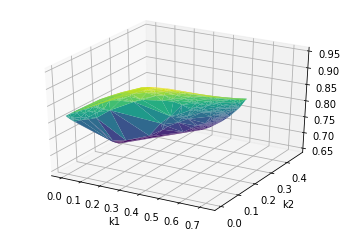

kobe


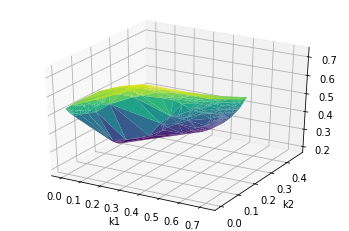

yield_val


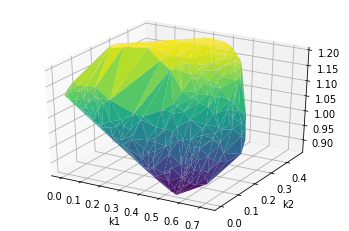

yieldAav


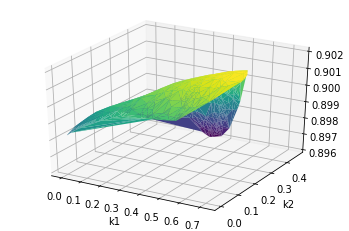

pollack
safety


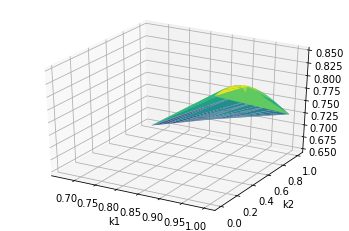

kobe


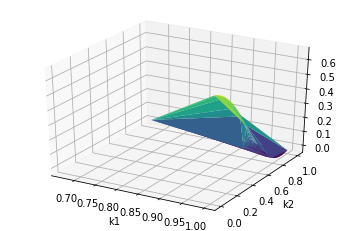

yield_val


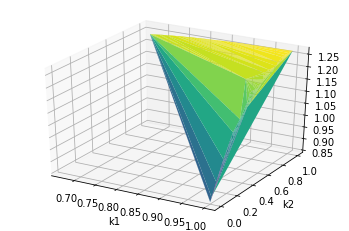

yieldAav


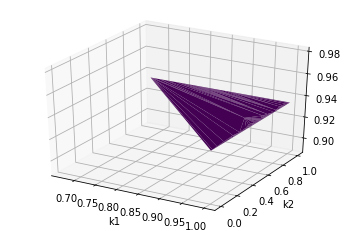

ray
safety


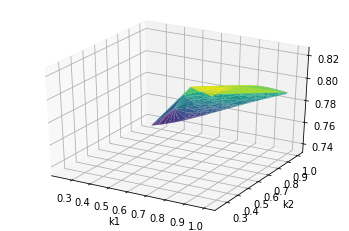

kobe


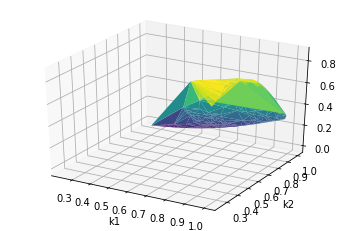

yield_val


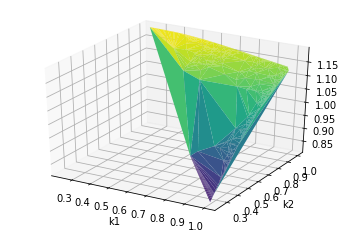

yieldAav


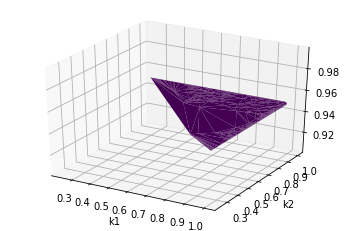

sprat
safety


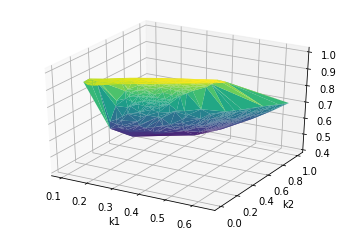

kobe


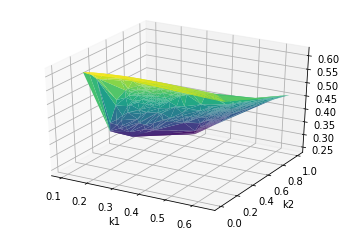

yield_val


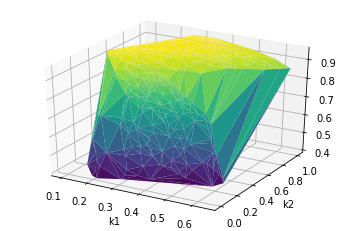

yieldAav


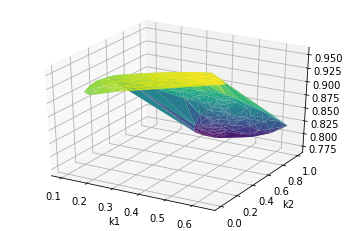

turbot
safety


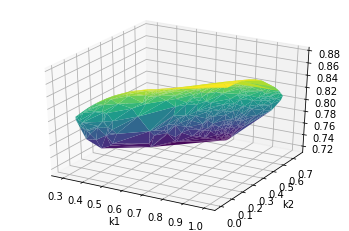

kobe


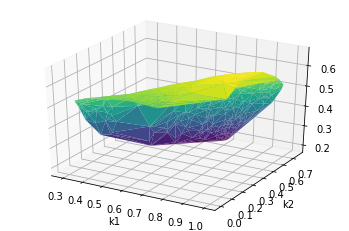

yield_val


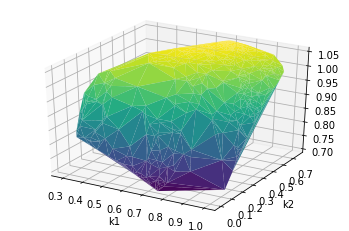

yieldAav


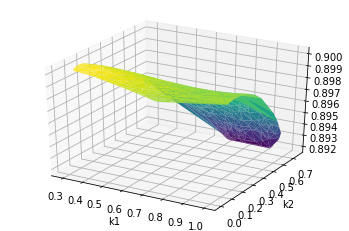

In [73]:
for dat, name in zip(each_stock_results, each_stock_results.axes[0]):
    print(name)
    df = pd.DataFrame(dat)
    df.columns = ['safety', 'kobe', 'yield_val', 'yieldAav', 'k1', 'k2']
    threeD_plotter(df)